In [28]:
import os, random, numpy as np
os.environ["CUDA_VISIBLE_DEVICES"] = ""

import torch
SEED = 1337
random.seed(SEED); np.random.seed(SEED); torch.manual_seed(SEED)
torch.set_num_threads(4)
DEVICE = torch.device("cpu")
DEVICE


device(type='cpu')

In [29]:
import pandas as pd

PATH = "/Users/dophi/Desktop/btl_doan2/crypto-prediction/data/processed/BTCUSDT_5m_features.csv"

df = pd.read_csv(PATH)
df["datetime"] = pd.to_datetime(df["datetime"])
df = df.sort_values("datetime").reset_index(drop=True)

In [30]:
n = len(df)
n_train = int(n * 0.70)
n_val   = int(n * 0.15)
n_test  = n - n_train - n_val

train_df = df.iloc[:n_train].copy()
val_df   = df.iloc[n_train:n_train+n_val].copy()
test_df  = df.iloc[n_train+n_val:].copy()

(len(train_df), len(val_df), len(test_df), df["datetime"].min(), df["datetime"].max())


(36674,
 7858,
 7860,
 Timestamp('2025-05-10 22:35:00'),
 Timestamp('2025-11-08 20:30:00'))

In [31]:
from sklearn.preprocessing import MinMaxScaler

FEATURE_COLS = [
    "close","high","low","volume",
    "MA_7","RSI_14",
    "price_change_pct","volume_change_pct",
    "hl_range_pct"
]
TARGET_COL = "close"

scaler_X = MinMaxScaler()
scaler_y = MinMaxScaler()

X_train = scaler_X.fit_transform(train_df[FEATURE_COLS].values)
y_train = scaler_y.fit_transform(train_df[[TARGET_COL]].values)

X_val   = scaler_X.transform(val_df[FEATURE_COLS].values)
y_val   = scaler_y.transform(val_df[[TARGET_COL]].values)

X_test  = scaler_X.transform(test_df[FEATURE_COLS].values)
y_test  = scaler_y.transform(test_df[[TARGET_COL]].values)


In [32]:
import numpy as np

def make_sequences(X, y, seq_len: int):
    Xs, ys = [], []
    for i in range(seq_len, len(X)):
        Xs.append(X[i-seq_len:i])
        ys.append(y[i])
    return np.array(Xs, dtype=np.float32), np.array(ys, dtype=np.float32)


In [33]:
import torch
import torch.nn as nn
from sklearn.metrics import mean_squared_error, r2_score
import math
import numpy as np

class LSTMRegressor(nn.Module):
    def __init__(self, n_features, hidden_size=128, num_layers=2, dropout=0.2):
        super().__init__()
        self.lstm = nn.LSTM(
            input_size=n_features,
            hidden_size=hidden_size,
            num_layers=num_layers,
            batch_first=True,
            dropout=dropout if num_layers > 1 else 0.0,
        )
        self.fc = nn.Linear(hidden_size, 1)

    def forward(self, x):
        out, _ = self.lstm(x)
        last = out[:, -1, :]
        return self.fc(last)


def rmse_percent(y_true, y_pred):
    rmse = math.sqrt(mean_squared_error(y_true, y_pred))
    return 100.0 * rmse / (np.mean(y_true) + 1e-8)


@torch.no_grad()
def evaluate(model, loader, scaler_y):
    model.eval()
    preds, trues = [], []
    for xb, yb in loader:
        out = model(xb.to(DEVICE))
        y_pred = scaler_y.inverse_transform(out.cpu().numpy())
        y_true = scaler_y.inverse_transform(yb.cpu().numpy())
        preds.append(y_pred)
        trues.append(y_true)

    y_pred = np.vstack(preds).squeeze()
    y_true = np.vstack(trues).squeeze()

    rmse = math.sqrt(mean_squared_error(y_true, y_pred))
    rmse_pct = rmse_percent(y_true, y_pred)
    r2 = r2_score(y_true, y_pred)

    return rmse, rmse_pct, r2, y_true, y_pred


In [34]:
# Cell 5: Dataloader + train_model in từng epoch
from torch.utils.data import TensorDataset, DataLoader
import time

def make_sequences(X, y, seq_len: int):
    Xs, ys = [], []
    for i in range(seq_len, len(X)):
        Xs.append(X[i-seq_len:i])
        ys.append(y[i])
    return np.array(Xs, dtype=np.float32), np.array(ys, dtype=np.float32)


def build_loaders(seq_len, batch_size):
    Xtr, ytr = make_sequences(X_train, y_train, seq_len)
    Xv,  yv  = make_sequences(X_val,   y_val,   seq_len)
    Xt,  yt  = make_sequences(X_test,  y_test,  seq_len)

    train_loader = DataLoader(
        TensorDataset(torch.tensor(Xtr), torch.tensor(ytr)),
        batch_size=batch_size, shuffle=True, drop_last=True
    )
    val_loader = DataLoader(
        TensorDataset(torch.tensor(Xv), torch.tensor(yv)),
        batch_size=batch_size, shuffle=False
    )
    test_loader = DataLoader(
        TensorDataset(torch.tensor(Xt), torch.tensor(yt)),
        batch_size=batch_size, shuffle=False
    )
    return train_loader, val_loader, test_loader


def train_model(cfg, verbose=True):
    seq_len    = cfg["seq_len"]
    hidden_size = cfg["hidden_size"]
    num_layers = cfg["num_layers"]
    dropout    = cfg["dropout"]
    lr         = cfg["lr"]
    batch_size = cfg["batch_size"]
    max_epochs = cfg["max_epochs"]
    patience   = cfg["patience"]

    print(f"🚀 Start training config: {cfg}", flush=True)

    train_loader, val_loader, test_loader = build_loaders(seq_len, batch_size)

    model = LSTMRegressor(
        n_features=len(FEATURE_COLS),
        hidden_size=hidden_size,
        num_layers=num_layers,
        dropout=dropout
    ).to(DEVICE)

    opt = torch.optim.Adam(model.parameters(), lr=lr)
    loss_fn = nn.MSELoss()

    best_val = float("inf")
    best_state = None
    best_epoch = 0
    wait = 0

    start_time = time.time()

    for epoch in range(1, max_epochs + 1):
        # ---- TRAIN ----
        model.train()
        train_losses = []
        for xb, yb in train_loader:
            xb, yb = xb.to(DEVICE), yb.to(DEVICE)
            opt.zero_grad()
            out = model(xb)
            loss = loss_fn(out, yb)
            loss.backward()
            nn.utils.clip_grad_norm_(model.parameters(), 1.0)
            opt.step()
            train_losses.append(loss.item())

        # ---- VALIDATION ----
        val_rmse, val_rmse_pct, _, _, _ = evaluate(model, val_loader, scaler_y)
        avg_train_loss = float(sum(train_losses) / len(train_losses))

        if verbose:
            print(
                f"Epoch {epoch:3d}/{max_epochs} | "
                f"TrainLoss={avg_train_loss:.6f} | "
                f"Val_RMSE%={val_rmse_pct:.3f}",
                flush=True
            )

        # ---- EARLY STOPPING ----
        if val_rmse_pct < best_val:
            best_val = val_rmse_pct
            best_state = model.state_dict()
            best_epoch = epoch
            wait = 0
        else:
            wait += 1
            if wait >= patience:
                if verbose:
                    print(f"Early stopping at epoch {epoch}", flush=True)
                break

    total_time = time.time() - start_time
    if verbose:
        print(f"\n⏱ Total training time: {total_time:.1f}s "
              f"(~{total_time/max(1,best_epoch):.2f}s/epoch, best_epoch={best_epoch})",
              flush=True)

    # load best weights
    model.load_state_dict(best_state)

    # final test metrics
    test_rmse, test_rmse_pct, test_r2, y_true, y_pred = evaluate(model, test_loader, scaler_y)

    return {
        "cfg": cfg,
        "model": model,
        "metrics": {
            "test_rmse": test_rmse,
            "test_rmse_pct": test_rmse_pct,
            "test_r2": test_r2,
        },
        "y_true": y_true,
        "y_pred": y_pred,
        "best_epoch": best_epoch,
        "train_time": total_time,
    }


In [35]:
cfg_single = {
    "seq_len": 120,
    "hidden_size": 128,
    "num_layers": 2,
    "dropout": 0.1,
    "lr": 1e-3,
    "batch_size": 64,
    "max_epochs": 100,
    "patience": 10,
}

result = train_model(cfg_single, verbose=True)

print("\n===== KẾT QUẢ TEST BTC 5m CHO CẤU HÌNH NÀY =====")
print("Config:", result["cfg"])
print(
    f"Test RMSE = {result['metrics']['test_rmse']:.4f} "
    f"({result['metrics']['test_rmse_pct']:.3f}%) | "
    f"R² = {result['metrics']['test_r2']:.4f}"
)
print(f"Best epoch: {result['best_epoch']}, "
      f"Train time: {result['train_time']:.1f}s")


🚀 Start training config: {'seq_len': 120, 'hidden_size': 128, 'num_layers': 2, 'dropout': 0.1, 'lr': 0.001, 'batch_size': 64, 'max_epochs': 100, 'patience': 10}
Epoch   1/100 | TrainLoss=0.002465 | Val_RMSE%=0.275
Epoch   2/100 | TrainLoss=0.000111 | Val_RMSE%=0.379
Epoch   3/100 | TrainLoss=0.000091 | Val_RMSE%=0.275
Epoch   4/100 | TrainLoss=0.000082 | Val_RMSE%=0.265
Epoch   5/100 | TrainLoss=0.000077 | Val_RMSE%=0.240
Epoch   6/100 | TrainLoss=0.000062 | Val_RMSE%=0.205
Epoch   7/100 | TrainLoss=0.000060 | Val_RMSE%=0.189
Epoch   8/100 | TrainLoss=0.000057 | Val_RMSE%=0.206
Epoch   9/100 | TrainLoss=0.000053 | Val_RMSE%=0.285
Epoch  10/100 | TrainLoss=0.000050 | Val_RMSE%=0.238
Epoch  11/100 | TrainLoss=0.000045 | Val_RMSE%=0.280
Epoch  12/100 | TrainLoss=0.000047 | Val_RMSE%=0.226
Epoch  13/100 | TrainLoss=0.000044 | Val_RMSE%=0.229
Epoch  14/100 | TrainLoss=0.000046 | Val_RMSE%=0.274
Epoch  15/100 | TrainLoss=0.000038 | Val_RMSE%=0.188
Epoch  16/100 | TrainLoss=0.000039 | Val_RMS

In [38]:
# Cell 8 — Save BTC 5m model

def ensure_dir(path):
    import os
    os.makedirs(path, exist_ok=True)

def save_checkpoint(symbol, model, cfg, feature_cols, target_col,
                    scaler_X, scaler_y, base_dir="/Users/dophi/Desktop/btl_doan2/crypto-prediction/models"):
    import time, torch, os
    
    ensure_dir(base_dir)
    ts = time.strftime("%Y%m%d_%H%M%S")
    filename = (
        f"{symbol}_5m_lstm_seq{cfg['seq_len']}_h{cfg['hidden_size']}_"
        f"L{cfg['num_layers']}_do{cfg['dropout']}_bs{cfg['batch_size']}_{ts}.pt"
    )
    path = os.path.join(base_dir, filename)

    payload = {
        "model_state_dict": model.state_dict(),
        "config": cfg,
        "symbol": symbol,
        "feature_cols": feature_cols,
        "target_col": target_col,
        "scaler_X": scaler_X,
        "scaler_y": scaler_y,
        "timestamp": ts,
    }

    torch.save(payload, path)
    print(f"✅ Saved BTCUSDT 5m checkpoint to: {path}")
    return path


# ---- Gọi hàm ở đây ----
save_checkpoint(
    symbol="BTCUSDT",
    model=result["model"],
    cfg=cfg_single,
    feature_cols=FEATURE_COLS,
    target_col=TARGET_COL,
    scaler_X=scaler_X,
    scaler_y=scaler_y,
)


✅ Saved BTCUSDT 5m checkpoint to: /Users/dophi/Desktop/btl_doan2/crypto-prediction/models/BTCUSDT_5m_lstm_seq120_h128_L2_do0.1_bs64_20251116_174732.pt


'/Users/dophi/Desktop/btl_doan2/crypto-prediction/models/BTCUSDT_5m_lstm_seq120_h128_L2_do0.1_bs64_20251116_174732.pt'

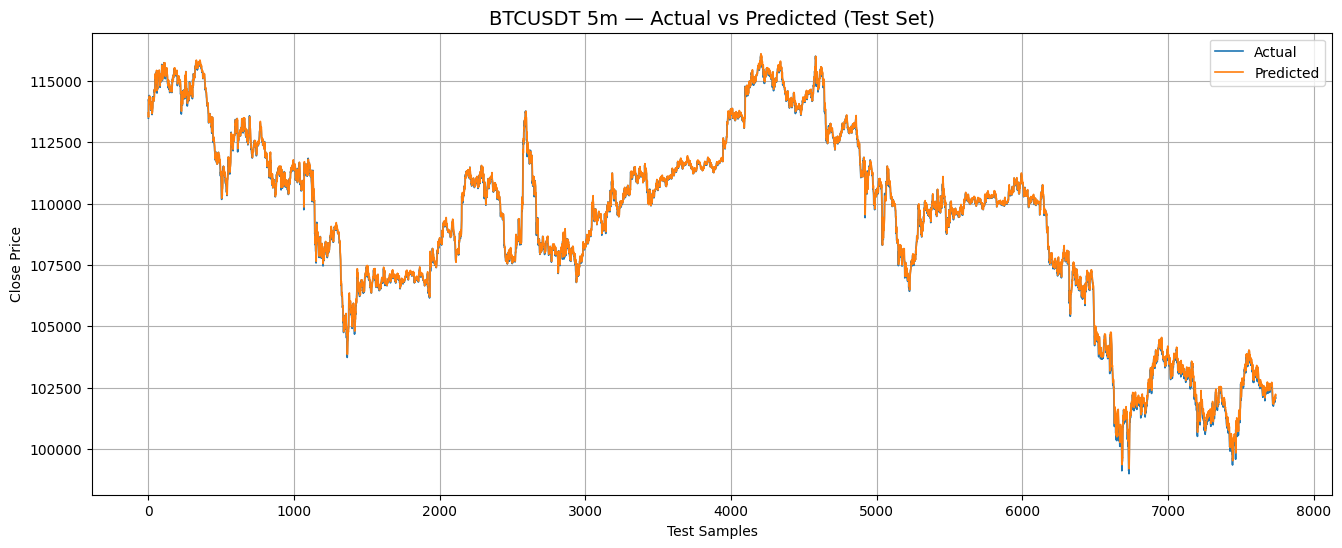

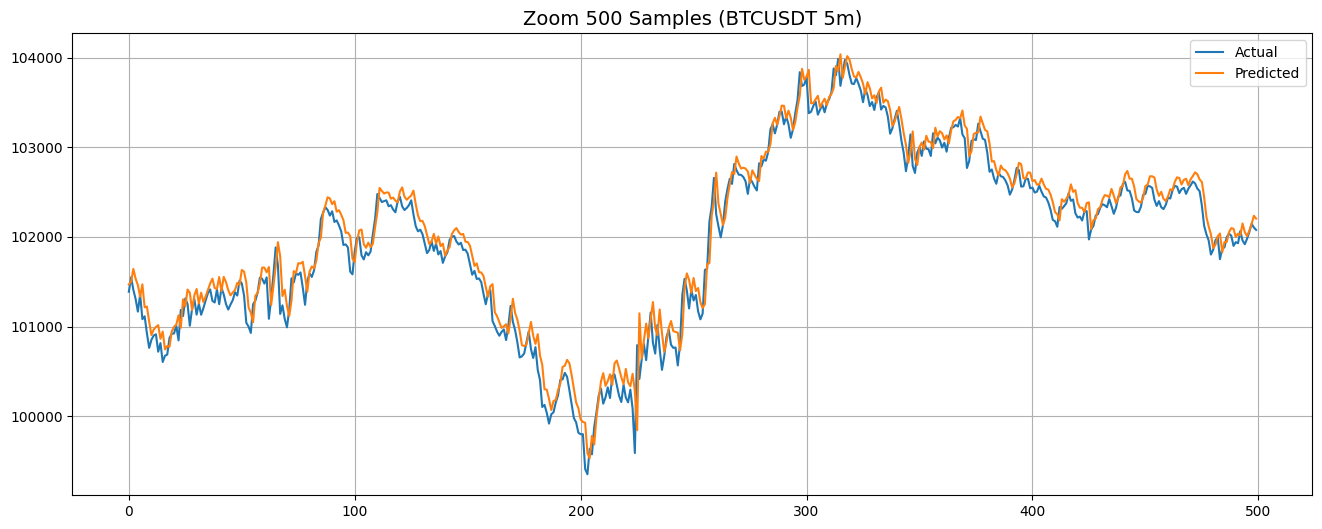

In [41]:
# Cell 9 — Plot Actual vs Predicted (Test set)

import matplotlib.pyplot as plt
import numpy as np

y_true = result["y_true"]
y_pred = result["y_pred"]

plt.figure(figsize=(16, 6))
plt.plot(y_true, label="Actual", linewidth=1.2)
plt.plot(y_pred, label="Predicted", linewidth=1.2)
plt.title("BTCUSDT 5m — Actual vs Predicted (Test Set)", fontsize=14)
plt.xlabel("Test Samples")
plt.ylabel("Close Price")
plt.legend()
plt.grid(True)
plt.show()

# ---- Zoom 500 mẫu cuối ----
plt.figure(figsize=(16, 6))
plt.plot(y_true[-500:], label="Actual")
plt.plot(y_pred[-500:], label="Predicted")
plt.title("Zoom 500 Samples (BTCUSDT 5m)", fontsize=14)
plt.grid(True)
plt.legend()
plt.show()

In [51]:
# Cell — In chỉ số đánh giá TEST của BTC 5m

test_metrics = result["metrics"]

print("\n===== BTC 5m Test Set Evaluation =====")
print(f"RMSE      : {test_metrics['test_rmse']:.4f}")
print(f"RMSE%     : {test_metrics['test_rmse_pct']:.4f}%")
print(f"R² Score  : {test_metrics['test_r2']:.6f}")
print(f"Test samples: {len(result['y_true'])}")



===== BTC 5m Test Set Evaluation =====
RMSE      : 163.3145
RMSE%     : 0.1495%
R² Score  : 0.998197
Test samples: 7740
